# 01 Baseline supervised

Let’s start with a simple supervised baseline on a tiny labeled MNIST subset.

We’ll use this as our reference point before introducing SSL.



Expected: accuracy climbs quickly then levels off well below fully supervised MNIST.



## Step 1: Imports and setup

We’ll pull in the data loader, model, and trainer.



In [5]:
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'src'))

from utils.seed import set_seed
from data.mnist import get_mnist_ssl
from models.small_cnn import SmallCNN
from train.trainer import run_supervised


## Step 2: Train the baseline

Train for a few epochs and record test accuracy each epoch.



In [6]:
set_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaders = get_mnist_ssl(
    data_dir='data',
    labeled_per_class=50,
    batch_size=128,
    num_workers=2,
    seed=0,
)

model = SmallCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
result = run_supervised(model, loaders.labeled, loaders.test, optimizer, DEVICE, epochs=5,
    use_progress=True,
)
result.history


100%|██████████| 9.91M/9.91M [00:01<00:00, 8.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 270kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.30MB/s]


[{'epoch': 0.0, 'test_acc': 0.4967},
 {'epoch': 1.0, 'test_acc': 0.5909},
 {'epoch': 2.0, 'test_acc': 0.7213},
 {'epoch': 3.0, 'test_acc': 0.7414},
 {'epoch': 4.0, 'test_acc': 0.7587}]

## Step 3: Plot the accuracy curve

This should climb quickly, then flatten as the model runs out of labeled signal.



(0.0, 1.0)

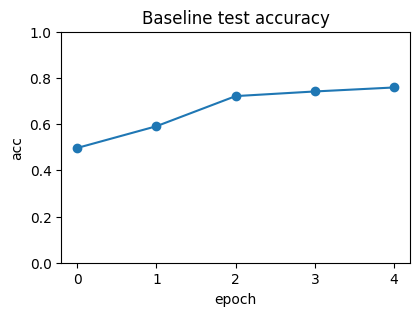

In [7]:
plt.figure(figsize=(4.5, 3))
plt.plot([h['epoch'] for h in result.history], [h['test_acc'] for h in result.history], marker='o')
plt.title('Baseline test accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.ylim(0, 1)


## Step 4: Confusion matrix

Look for persistent confusions that a stronger semi‑supervised loop could resolve.



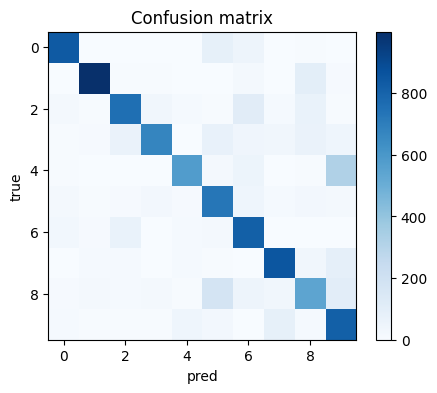

In [8]:
# Confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in loaders.test:
        images = images.to(DEVICE)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_labels.append(labels)

preds = torch.cat(all_preds)
labels = torch.cat(all_labels)
cm = torch.zeros(10, 10, dtype=torch.int64)
for t, p in zip(labels, preds):
    cm[t, p] += 1

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('pred')
plt.ylabel('true')
plt.colorbar()


### Expected Outcome

With 50 labels per class on MNIST, the supervised model should improve quickly over a few epochs.


## Observations → Why → SSL opportunity

**What you’ll likely see**

- Accuracy improves fast, then plateaus.

- A few digit pairs stay confusing (e.g., 4 vs 9, 3 vs 5).



**Why this happens**

- With few labels, the model learns only coarse boundaries.

- Limited labels also mean weaker calibration and more overconfident mistakes.



**Where SSL can help**

- Unlabeled data can refine boundaries and reduce those persistent confusions.

- The next notebooks show when recursion helps and when it hurts.

